# Toy Model: Analysis

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd
import scipy.stats as st


# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')
plt.rcParams['savefig.dpi'] = 400 

from sbin.complexity import gap_complexity, ecdf_confidence
import seaborn as sns 

from sbin.sbin import suppression_simulation
import sbin.parameters as param
param.radius_valley = 0.

do_multiplicity=True
sup_style='planets'
sup_method='simple'


if sup_method=='simple':
    from sbin.sbin import suppression_factor_simple as my_suppression_factor
elif sup_method=='moekratter':
    from sbin.sbin import suppression_factor as my_suppression_factor
elif sup_method=='50':
     from sbin.sbin import suppression_factor_50 as my_suppression_factor   
else:
    raise




### Read in data saved from Filtering

In [2]:
with open("filtered_data.pkl", "rb") as f:
     data = pickle.load(f)
              
close = data["close"]
good = data["good"]
db_filtered = data["db_filtered"]
kois_filtered = data["kois_filtered"]
kois_good = data["kois_good"]
cks_filtered = data["cks_filtered"]
cks_good = data["cks_good"]

if not do_multiplicity:
    print("Filtering on prad err")
    kois_filtered = data["kois_filtered"][kois_good]
    cks_filtered = data["cks_filtered"][cks_good]

In [3]:
# separation values (as lists) for each star in binary sample
# for use in the simulation
tmp = db_filtered[good & close].groupby('KOI')['SepAU'].agg('unique')
binary_separations = np.concatenate(tmp.to_numpy())

# Toy Model

### Suppress the KOIs

In [4]:
ntrials = 100
 
# define bins for recording plotting
nbins=20
lin_histrange=[0.5,4.5]
lin_bin_edges = np.linspace(lin_histrange[0], lin_histrange[1], nbins + 1)
log_histrange=[np.log10(0.7),np.log10(6)]
log_bin_edges = np.logspace(log_histrange[0], log_histrange[1], nbins + 1)

# run trials and save the results
koi_sim_linear = np.ones((ntrials,nbins))
koi_sim_log = np.ones((ntrials,nbins))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)

complexity_sim = [None]*ntrials
a_values_sim = [None]*ntrials
koi_npl_sim = [None]*ntrials

for i in range(ntrials):
    obs, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(
        kois_filtered, separations=None, join_on='KOI', prad_col='koi_prad', 
        sup_function=my_suppression_factor, sup_type = sup_style)
    nplanets = len(obs)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    
    # histogram of planet radii (linear)
    hist, _ = np.histogram(obs['koi_prad'], 
            range=lin_histrange, bins=lin_bin_edges, weights=ww)
    koi_sim_linear[i] = hist
    
    # histogram of planet radii (log)
    hist, _ = np.histogram(obs['koi_prad'], 
            range=log_histrange, bins=log_bin_edges, weights=ww)
    koi_sim_log[i] = hist
    
    #  n_planets
    koi_npl_sim[i] = sim_counts['n_planets'].values
    
    # complexity metric
    complexity_df = (obs
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: obs.groupby('KOI').size().values)
            )
    complexity_sim[i] = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values
    a_values_sim[i] = obs['a_values']
    
# save complexity percentiles for ecdf
pickle.dump(ecdf_confidence(complexity_sim), open('kois_complexity_'+sup_method+'_'+sup_style+'.pkl', 'wb'))
_, _, median, _ = ecdf_confidence(complexity_sim)

low, koi_prad_linear, high = np.percentile(koi_sim_linear, q=(2.25,50,98.75), axis=0)
e_koi_prad_linear = (high-low)/2

low, koi_prad_log, high = np.percentile(koi_sim_log, q=(2.25,50,98.75), axis=0)
e_koi_prad_log = (high-low)/2

koi_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))
print("se fraction", koi_SE_frac)

print("occurrence", len(obs), len(kois_filtered))

if do_multiplicity:
    koi_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
    print("mtps fraction", koi_MTPS_frac)

se fraction [0.44518086 0.46122239 0.48615822 0.50055487 0.52621166]
occurrence 517 2799
mtps fraction [0.11429559 0.13180808 0.15092084 0.16808276 0.18017139]


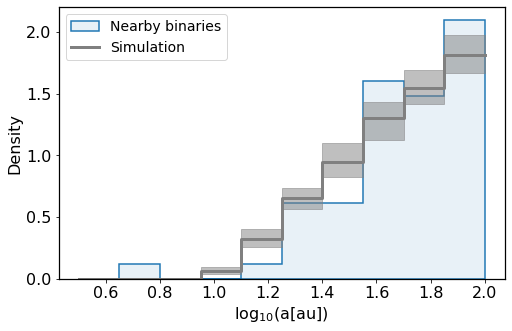

In [5]:
def a_values_plot(binary_separations, a_values_sim):
    
    log_min, log_max = 0.5, 2.0              
    n_bins = 10                              
    bins   = np.linspace(log_min, log_max, n_bins + 1)   # bin edges
    bin_centers = 0.5 * (bins[:-1] + bins[1:])           # for plotting

    hists = []
    for x in a_values_sim:
        count, _ = np.histogram(np.log10(x), bins=bins, density=True)
        hists.append(count)

    # simulation shenanigans
    hists = np.asarray(hists)              
    median_h  = np.median(hists, axis=0)               # median density
    lower_h   = np.percentile(hists, 16, axis=0)       # 16 th percentile
    upper_h   = np.percentile(hists, 84, axis=0)       # 84 th percentile
    lower_step = np.r_[lower_h, lower_h[-1]]
    upper_step = np.r_[upper_h,  upper_h[-1]]
    median_step = np.r_[median_h,  median_h[-1]]

    fig, ax = plt.subplots(figsize=(8, 5))

    plt.hist(np.log10(binary_separations), 
             density=True, bins=bins, histtype='stepfilled',
             edgecolor='#1f77b4', facecolor='#e8f1f7', lw=1.5, label='Nearby binaries')

    # 68 % confidence band
    ax.step(bins, median_step, where='post',
            color='gray', lw=3,
            label='Simulation')
    ax.fill_between(bins, lower_step, upper_step, step='post',
                    color='gray', alpha=0.5)



    ax.set_xlabel(r'$\log_{10}(a [au])$')
    ax.set_ylabel('Density')
    plt.legend(loc='upper left')
    
    return fig

fig = a_values_plot(binary_separations, a_values_sim)

plt.savefig('kois_loga_'+sup_method+'_'+sup_style+'.png')

###  Suppress CKS

In [6]:
# run trials and save the results
cks_sim_linear = np.ones((ntrials,nbins))
cks_sim_log = np.ones((ntrials,nbins))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)

complexity_sim = [None]*ntrials
a_values_sim = [None]*ntrials
cks_npl_sim = [None]*ntrials

for i in range(ntrials):
    obs, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(
        cks_filtered, separations=None, join_on='KOI', prad_col='Rp', 
        sup_function=my_suppression_factor, sup_type = sup_style)
    nplanets = len(obs)
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    
    # histogram of planet radii (linear)
    hist, _ = np.histogram(obs['Rp'], 
            range=lin_histrange, bins=lin_bin_edges, weights=ww)
    cks_sim_linear[i] = hist
    
    # histogram of planet radii (log)
    hist, _ = np.histogram(obs['Rp'], 
            range=log_histrange, bins=log_bin_edges, weights=ww)
    cks_sim_log[i] = hist
    
    #  n_planets
    cks_npl_sim[i] = sim_counts['n_planets']
    
    # complexity metric
    complexity_df = (obs
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: obs.groupby('KOI').size().values)
            )
    complexity_sim[i] = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values
    a_values_sim[i] = obs['a_values']
    
# save complexity percentiles for ecdf
pickle.dump(ecdf_confidence(complexity_sim), open('cks_complexity_'+sup_method+'_'+sup_style+'.pkl', 'wb'))
_, _, median, _ = ecdf_confidence(complexity_sim)

low, cks_prad_linear, high = np.percentile(cks_sim_linear, q=(2.25,50,98.75), axis=0)
e_cks_prad_linear = (high-low)/2

low, cks_prad_log, high = np.percentile(cks_sim_log, q=(2.25,50,98.75), axis=0)
e_cks_prad_log = (high-low)/2

cks_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))
print("se fraction", cks_SE_frac)

print("occurrence", len(obs), len(cks_filtered))

if do_multiplicity:
    cks_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
    print("mtps fraction", cks_MTPS_frac)

se fraction [0.44559298 0.47696262 0.52762515 0.56783777 0.61241062]
occurrence 150 873
mtps fraction [0.12368509 0.14754098 0.17741935 0.21456931 0.23697731]


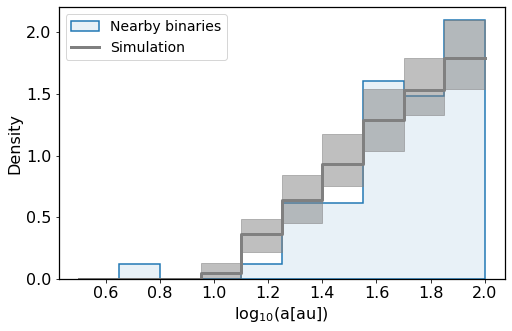

In [7]:
fig = a_values_plot(binary_separations, a_values_sim)

plt.savefig('cks_loga_'+sup_method+'_'+sup_style+'.png')

# Plot the results

### Radius

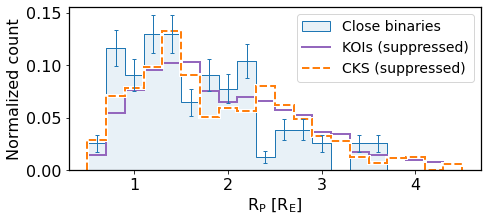

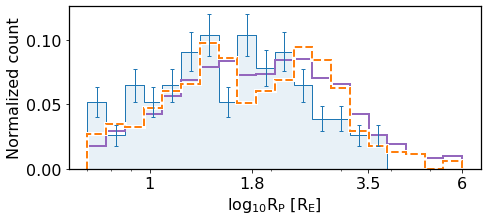

In [8]:
from scipy.stats import gaussian_kde

for option in ['linear','log']:
    
    if option=='linear':
        my_bins=lin_bin_edges
        my_prad_k=koi_prad_linear
        e_my_prad_k=e_koi_prad_linear
        my_prad_c=cks_prad_linear
        e_my_prad_c=e_cks_prad_linear
    else:
        my_bins=log_bin_edges
        my_prad_k=koi_prad_log
        e_my_prad_k=e_koi_prad_log
        my_prad_c=cks_prad_log
        e_my_prad_c=e_cks_prad_log
       
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    # planets with good radii in binary systems with rho<100 au and planet period < 100 days
    nplanets = len(db_filtered[good & close])
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    y, _, _ = plt.hist(db_filtered['Rppri'][good & close], 
                 bins=my_bins, weights=ww,
             histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
            label='Close binaries')

    plt.hist(db_filtered['Rppri'][good & close], 
                 bins=my_bins, weights=ww,
                 histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')
    x = my_bins[:-1]+np.diff(my_bins)/2.
    plt.errorbar(x, y, np.sqrt(y)/len(y), ls='None', lw=1, capsize=2, c='C0')


    x = my_bins[:-1]+np.diff(my_bins)/2.
    plt.stairs(my_prad_k, my_bins, color='C4', linewidth=2, label='KOIs (suppressed)')
    #plt.errorbar(x, my_prad_k, e_my_prad_k, c='C4', ls='None', lw=2, capsize=2)
    plt.stairs(my_prad_c, my_bins, color='w', linewidth=4)
    plt.stairs(my_prad_c, my_bins, color='C1', linestyle='--',linewidth=2, label='CKS (suppressed)')
    #plt.errorbar(x, my_prad_c, e_my_prad_c, c='C1', ls='None', lw=2, capsize=2)

    #y = np.concatenate(([0], cks_prad_sim, [0]))
    #plt.errorbar(bin_center-0.02, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')
    #plt.errorbar(bin_center+0.025, cks_prad_sim, e_cks_prad_sim, ls='None', lw=2, capsize=2, c='C1')

    #plt.text(0.98, 0.95, 'KOIs & CKS: $R_P>1.7 R_E$ suppressed',
    #     horizontalalignment='right',
    #     verticalalignment='top',
    #     fontsize=12,
    #     transform = axes.transAxes)


    if option=='linear':
        plt.legend()
        plt.xlabel('$R_P$ [$R_E$]')        
    else:
        plt.xlabel('$log_{10} R_P$ [$R_E$]')  
        plt.xscale('log')
        
        custom_log_ticks = [1, 1.8, 3.5, 6]
        plt.gca().set_xticks(custom_log_ticks)
        plt.gca().set_xticklabels([str(t) for t in custom_log_ticks])

    plt.ylabel('Normalized count')
    plt.tight_layout()

    if ~do_multiplicity:
        plt.savefig('suppression_'+option+'_'+sup_method+'_'+sup_style+'.png')

### Multiplicity

In [9]:
with open("filtered_data_thebault.pkl", "rb") as f:
     datatb = pickle.load(f)
mpl.rcParams['figure.subplot.hspace'] = 0.1
       

In [10]:
def multiplicity_hist(sim_results):
    
    sim_npl = np.ones((ntrials, 5))
    for i,vv in enumerate(sim_results):
        nstars = len(vv)
        ww = 1./np.full(nstars, nstars, dtype=float)
        hist, _ = np.histogram(vv, weights=ww, 
                               bins=[0.5,1.5,2.5,3.5,4.5,5.5])
        sim_npl[i] = hist
    y = np.percentile(sim_npl, q=50, axis=0)
    
    return y


def multiplicity_figure(db_filtered, datatb, kois_filtered, cks_filtered,
                        sample='sullivan'):
    
    if sample=='sullivan':
        wide_planet_counts = db_filtered[~close].groupby('KOI').size().reset_index(name='n_planets')
        close_planet_counts = db_filtered[close].groupby('KOI').size().reset_index(name='n_planets')
        koi_planet_counts = kois_filtered.groupby('KOI').size().reset_index(name='n_planets')
        cks_planet_counts = cks_filtered.groupby('KOI').size().reset_index(name='n_planets')
        ec='#1f77b4'
        fc='#e8f1f7'
    elif sample=='tb':
        wide_planet_counts = datatb['db_filtered'][~datatb['close']].groupby('KOI').size().reset_index(name='n_planets')
        close_planet_counts = datatb['db_filtered'][datatb['close']].groupby('KOI').size().reset_index(name='n_planets')
        sullivan_close_planet_counts = db_filtered[close & (db_filtered['koi_disposition']=='CONFIRMED')].groupby('KOI').size().reset_index(name='n_planets')
        koi_planet_counts = kois_filtered[kois_filtered['koi_disposition']=='CONFIRMED'].groupby('KOI').size().reset_index(name='n_planets')
        cks_planet_counts = cks_filtered[cks_filtered['koi_disposition']=='CONFIRMED'].groupby('KOI').size().reset_index(name='n_planets')
        ec='#3c903c'
        fc='#eefaf0'
        
    fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)
    x = np.array([1,2,3,4,5])

    ## panel for the binaries

    nstars = len(close_planet_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    y, _ = np.histogram(close_planet_counts['n_planets'], 
                        weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    for ax in axes:
        ax.bar(x, y, edgecolor=ec, facecolor=fc, 
                width=0.9, linewidth=1.5, label='Nearby binaries')

    nstars = len(wide_planet_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    y, _ = np.histogram(wide_planet_counts['n_planets'],  
                        weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    for ax in axes:
        ax.bar(x, y, edgecolor='gray', facecolor='None', linestyle="--", 
                width=0.9, linewidth=1.5, label='Wide binaries')


    ## add raw planet counts

    nstars = len(koi_planet_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    y, _ = np.histogram(koi_planet_counts['n_planets'], 
                        weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    axes[0].bar(x-0.2, y, edgecolor='C4', facecolor='C4',  
                width=0.3, lw=1.5, label='KOIs')

    nstars = len(cks_planet_counts)
    ww = 1./np.full(nstars, nstars, dtype=float)
    y, _ = np.histogram(cks_planet_counts['n_planets'], 
                        weights=ww, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    axes[0].bar(x+0.2, y, edgecolor='white', facecolor='None',  
                width=0.3, lw=4)
    axes[0].bar(x+0.2, y, edgecolor='C1', facecolor='None',  
                width=0.3, lw=2, label='CKS')



    ## panel for suppressed planet counts
    
    y = multiplicity_hist(koi_npl_sim)
    axes[1].bar(x-0.2, y, edgecolor='C4', facecolor='C4',  
                width=0.3, lw=1.5, label='KOIs (planets suppressed)')

    y = multiplicity_hist(cks_npl_sim)
    axes[1].bar(x+0.2, y, edgecolor='white', facecolor='None',  
                width=0.3, lw=4)
    axes[1].bar(x+0.2, y, edgecolor='C1', facecolor='None',  
                width=0.3, lw=2, label='CKS (planets suppressed)')


    for ax in axes:
        ax.set_ylabel('Normalized count')
        ax.set_ylim(0,0.9)
    axes[0].legend()
    axes[1].text(0.98,0.9, 'Planets suppressed\nper Moe & Kratter',
                transform=ax.transAxes, ha='right', va='top')


    plt.xlabel('Number of planets per star')
    plt.tight_layout(h_pad=0.4)
        
        
    # Statistics
    
    print(st.mannwhitneyu(close_planet_counts['n_planets'], koi_planet_counts['n_planets'], alternative='two-sided'))

    results = [st.mannwhitneyu(close_planet_counts['n_planets'], x, alternative='two-sided') for x in koi_npl_sim]
    results = np.asarray(results, dtype=float)   # shape = (Nsim, 2)

    U_stats = results[:, 0]      # array of U‑statistics
    p_values  = results[:, 1]      # array of p‑values
    print(np.percentile(p_values, q=[16,50,84]))
    
    return fig


MannwhitneyuResult(statistic=40886.5, pvalue=0.1387880883034657)
[1.96759500e-05 1.18254672e-04 4.66616424e-04]


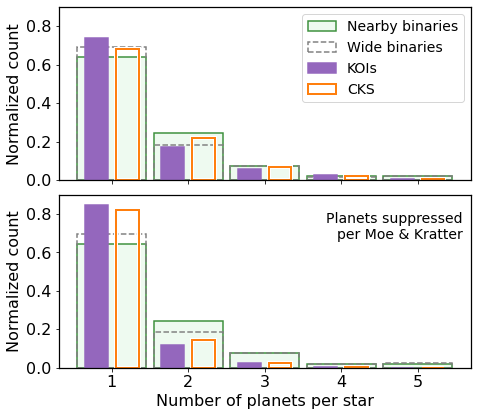

In [11]:
fig = multiplicity_figure(db_filtered, datatb, kois_filtered, cks_filtered, 'tb')
if do_multiplicity:
    plt.savefig('multiplicity_tb_'+sup_method+'_'+sup_style+'.png')


MannwhitneyuResult(statistic=60641.5, pvalue=0.3717703363493645)
[0.00084988 0.0035026  0.0098011 ]


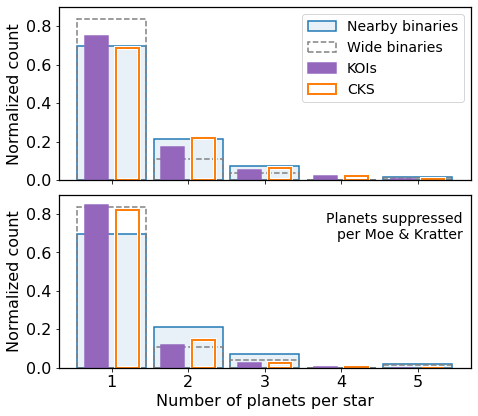

In [12]:
fig = multiplicity_figure(db_filtered, datatb, kois_filtered, cks_filtered, 'sullivan')
if do_multiplicity:
    plt.savefig('multiplicity_sullivan_'+sup_method+'_'+sup_style+'.png')
